In [2]:
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from unsuper import *
import seaborn as sns

sns.set_style('ticks')
sns.set(font_scale=1.5)

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from pyclustering.cluster import optics


import os   # For os related operations
import sys  # For data size
%matplotlib inline

Using TensorFlow backend.


In [3]:
data = load_data(monte=False)
#X=data
#print(X.shape)
inputs_col = pd.DataFrame()

data['u-g']=data['u']-data['g']
data['g-r']=data['g']-data['r']
data['r-i']=data['r']-data['i']
data['i-z']=data['i']-data['z']
data['z-y']=data['z']-data['y']
data['u-G']=data['u']-data['G']
data['u-RP']=data['u']-data['RP']
data['u-BP']=data['u']-data['BP']

#X = data[['u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'u-G', 'u-RP', 'u-BP']].copy()
#X = normalize(X_input)
X2 = data[['u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'u-G', 'u-RP', 'u-BP',  'Teff', 'logg', 'feh']].copy()
X = data[['u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'u-G', 'u-RP', 'u-BP']].copy()

In [4]:
# find spread for each dimension
X.shape

(14275, 8)

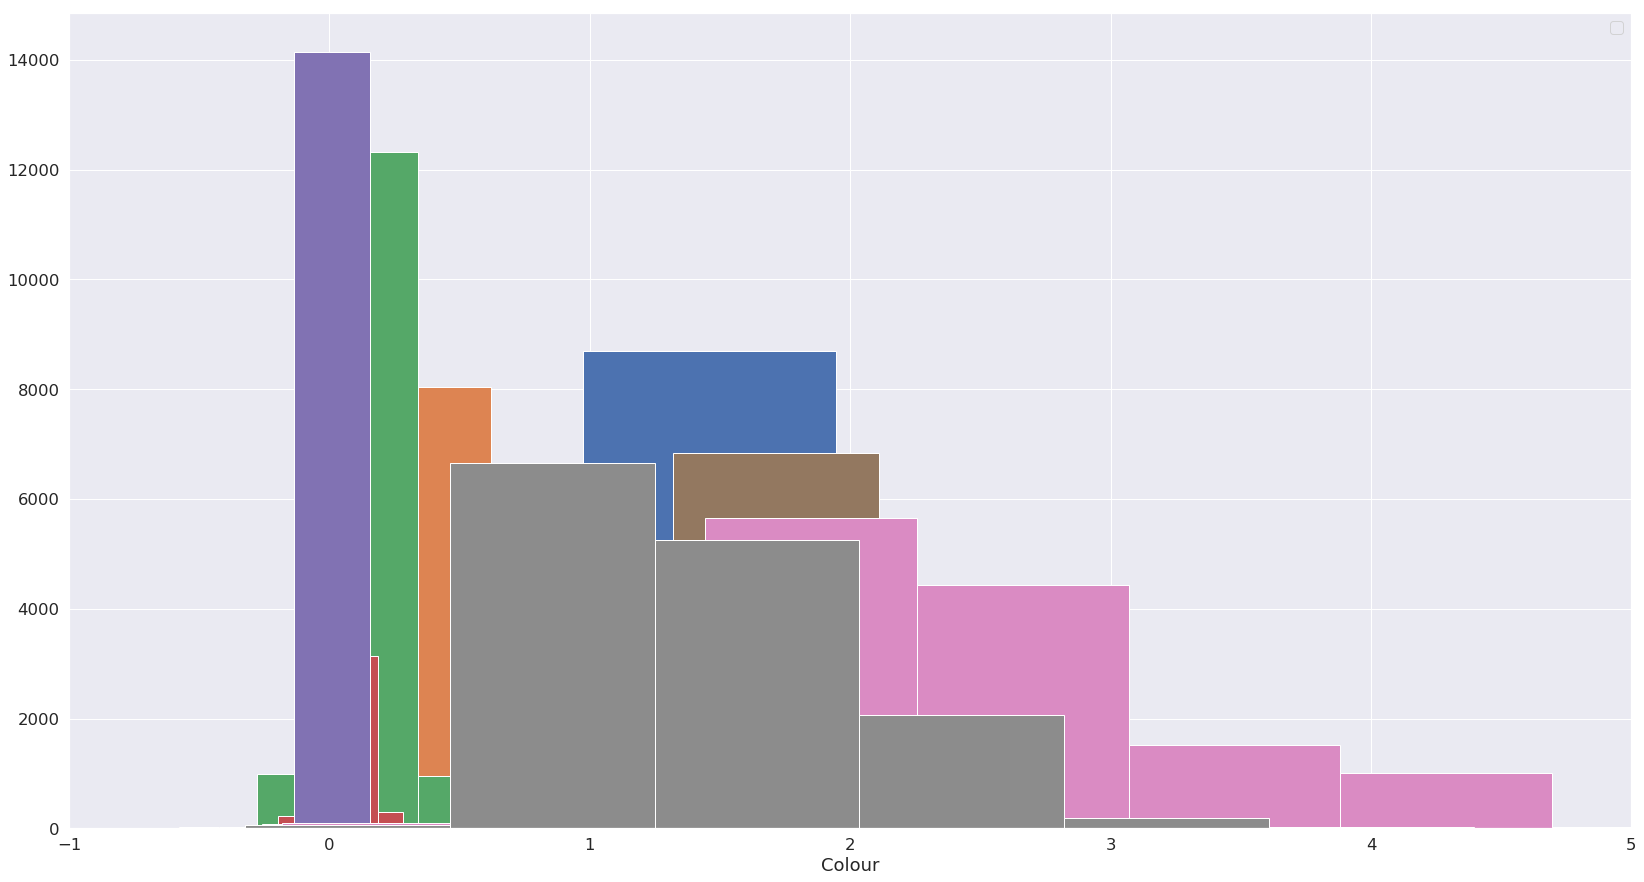

/opt/conda/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


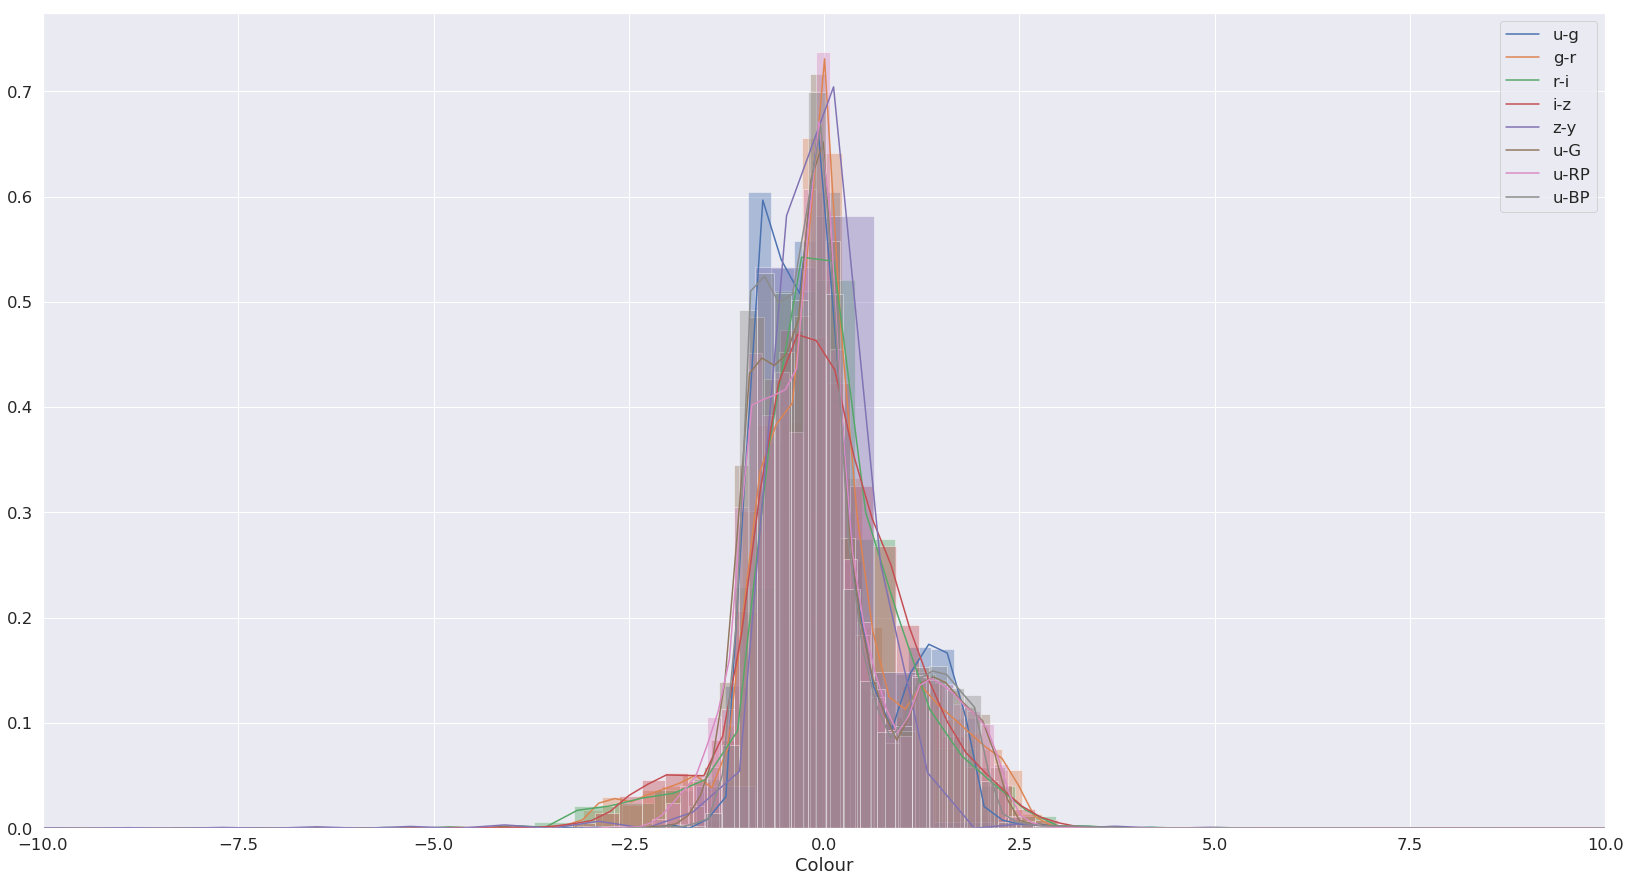

In [5]:
N = int(0.01*X.shape[0])

X_norm = normalize(X)
X2_norm = normalize(X2)

X_norm = X_norm
X2_norm = X2_norm

reach_size = (28, 15)
fig, ax = plt.subplots(figsize=reach_size)

for column in X.head():
    #bins=np.linspace(min(X[column]), max(X[column]) + binwidth, binwidth)
    plt.hist(X[column], bins=20)#kde_kws={"label": column}, bins=10)
    ax.set_xlim(-1, 5)
    ax.set_xlabel('Colour')
    ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=reach_size)
for column in X_norm.head():
    ax = sns.distplot(X_norm[column], kde_kws={"label": column}, bins=100)
    ax.set_xlim(-10, 10)
    ax.set_xlabel('Colour')
    ax.legend()
plt.show()

In [6]:
from sklearn.cluster import OPTICS
sklearn.__version__

clust = OPTICS(min_samples=N, rejection_ratio=0.01, max_eps=40.)
import hdbscan


# Run the fit
clust.fit(X_norm)

#clusterer = hdbscan.RobustSingleLinkage(cut=0.16, k=7)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=N).fit(X_norm)

/home/nannau/.local/lib/python2.7/site-packages/sklearn/cluster/optics_.py:548: RuntimeWarning: invalid value encountered in true_divide
  reachability = reachability / np.max(reachability[1:])


OPTICS(algorithm='ball_tree', leaf_size=30, max_eps=40.0, maxima_ratio=0.75,
    metric='euclidean', metric_params=None, min_cluster_size_ratio=0.005,
    min_maxima_ratio=0.001, min_samples=142, n_jobs=None, p=2,
    rejection_ratio=0.01, significant_min=0.003, similarity_threshold=0.4)

In [69]:
eps = 0.275#445
X_clust = X2.copy()

# Get reachability plot axis
X_clust['reachability'] = clust.reachability_[clust.ordering_]
X_clust['space'] = range(0, len(X_clust['reachability']))#clust.labels_[clust.ordering_]

# Get indeces of clusters
indeces = clust.extract_dbscan(eps)[0]
#print X_clust.shape, len(clust.extract_dbscan(eps)[1])
X_clust['labels'] = clust.extract_dbscan(eps)[1]
#X_clust['label_reach'] = clust.extract_dbscan(eps)[1]

X_clust['reachability'] = clust.reachability_[clust.ordering_]
X_clust['space'] = range(0, len(X_clust['reachability']))#clust.labels_[clust.ordering_]

#df = X_clust.copy()
#X_clust['label'] = np.sign(X_clust['reachability']-eps)

(14275, 14)


Text(0.5,1,'Reachability Plot')

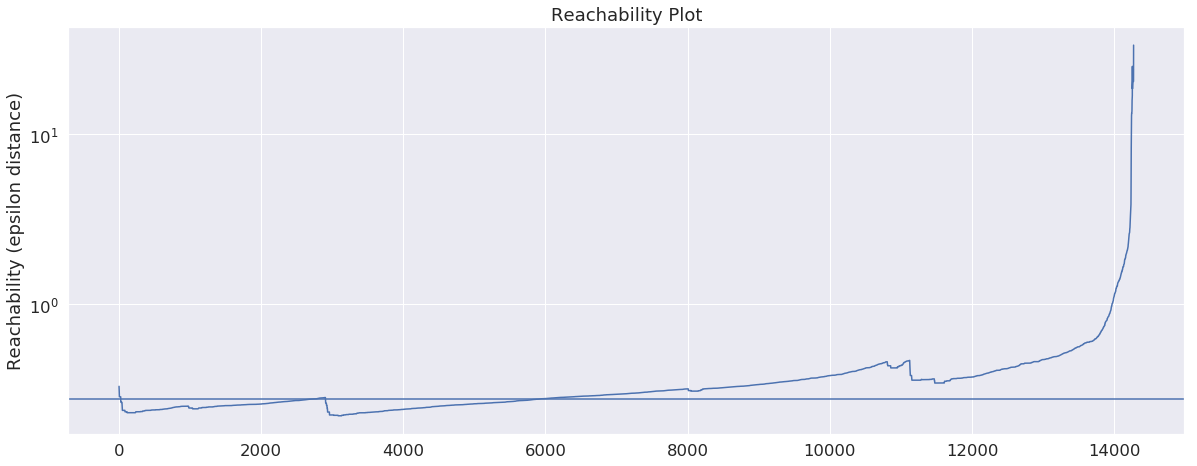

In [70]:
reach_size = (20, 7.5)
fig, ax = plt.subplots(figsize=reach_size)
print X_clust.shape
# Reachability plot
ax.set_yscale("log")
ax.plot(X_clust['space'], X_clust['reachability'], '-')
#ax.scatter(X_clust['space'], X_clust['reachability'], c=X_clust['labels'])
ax.axhline(eps)
ax.set_ylabel('Reachability (epsilon distance)')
ax.set_title('Reachability Plot')

In [71]:
#def clust_finder(df, eps):

def optics_labeller(df, eps):
    df_copy = df.copy()
    df['label'] = pd.Series(np.sign(df_copy['reachability']-eps))
    df['optics_label'] = pd.Series(df_copy.index.values)
    
    indx = df_copy.loc[df['label'].diff() != 0.0].index.values
    x = df_copy.index.values
    
    for i in range(0, len(indx)-1):
        df['optics_label'].loc[indx[i]:indx[i+1]] = i
        if df['label'].loc[indx[i]] > 0:
            df['optics_label'].loc[indx[i]:] = len(indx)
    return df

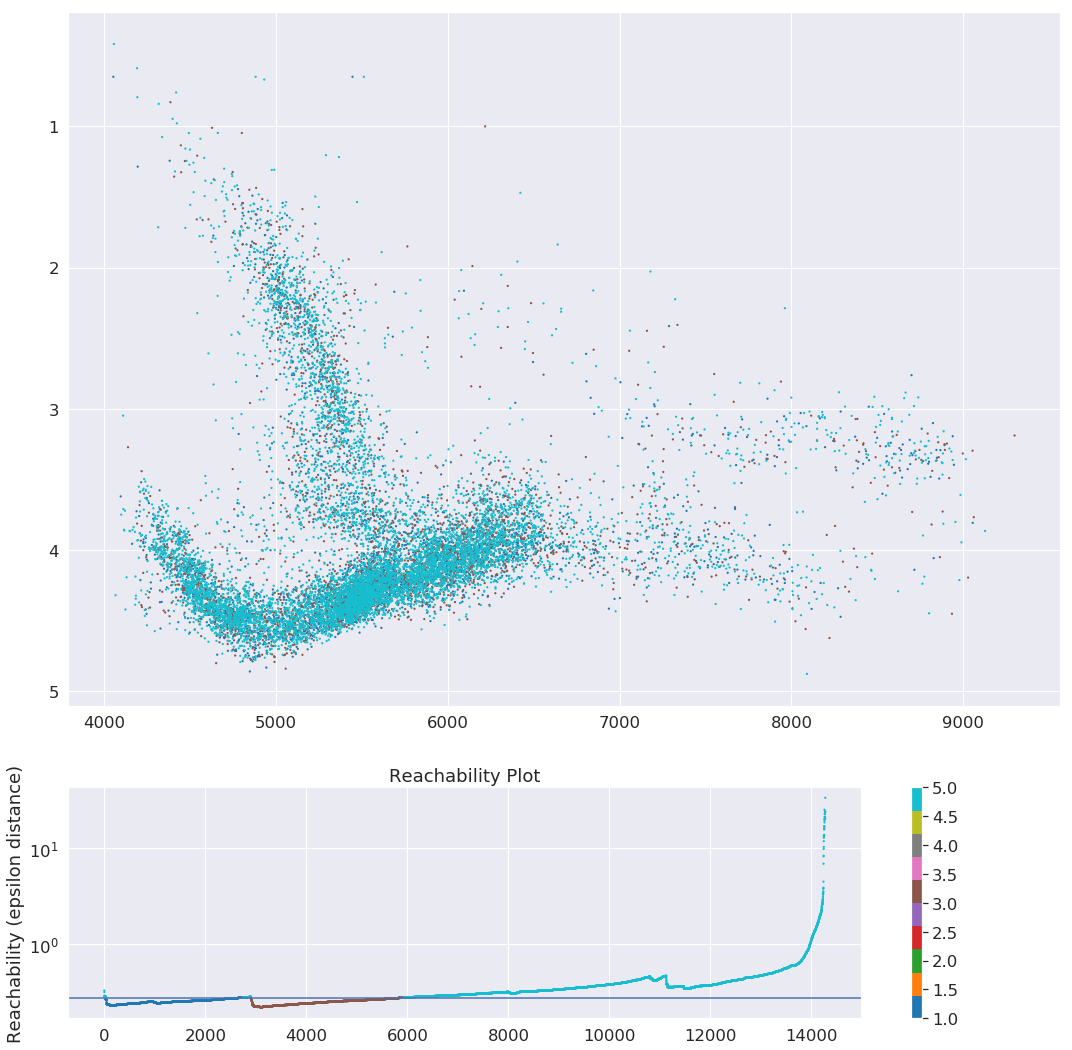

In [72]:
reach_size = (20, 7.5)

X_labelled = optics_labeller(X_clust, eps)
#X_labelled = X_labelled[(X_labelled['optics_label']!=5)]


fig = plt.figure(figsize=(15, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax0.invert_yaxis()
ax0.scatter(X_labelled['Teff'], X_labelled['logg'], c=X_labelled['optics_label'], s=1.5, cmap=plt.cm.tab10)
ax1 = plt.subplot(gs[1])
data = ax1.scatter(X_labelled['space'], X_labelled['reachability'], c=X_labelled['optics_label'], cmap=plt.cm.tab10, s=1.5)
ax1.set_yscale("log")
ax1.axhline(eps)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')
fig.colorbar(data, ax=ax1)
plt.tight_layout()

1
2
3


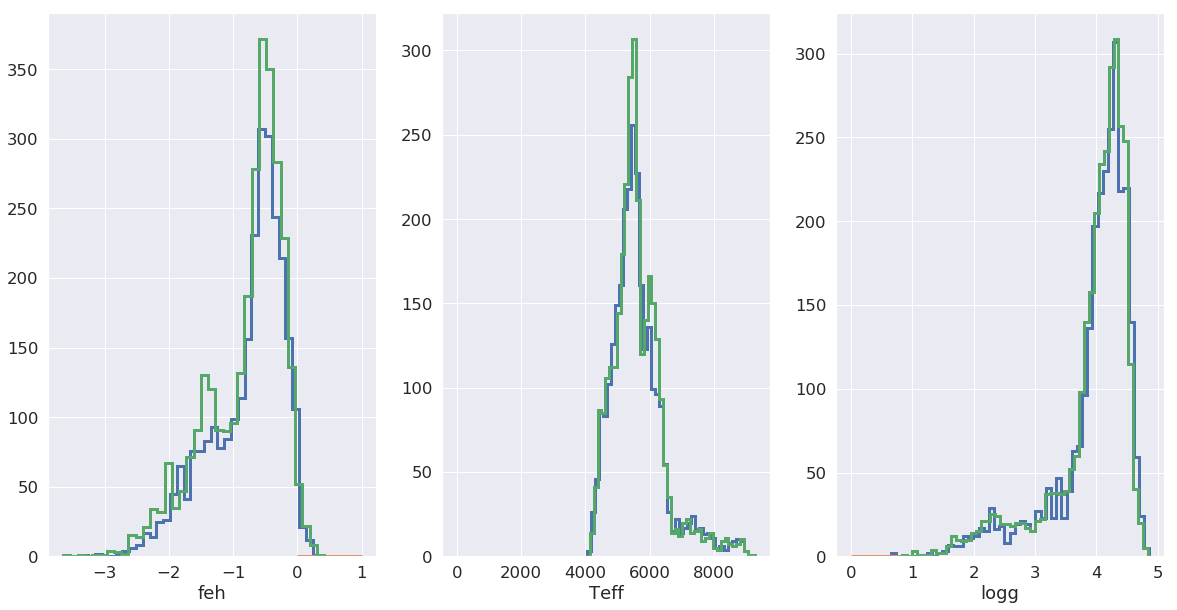

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,10))#, #sharey=True)
max_cluster = X_labelled['optics_label'].nunique()
for i in range(1,4):
    print i
    X_clust_label = X_labelled.loc[X_labelled['optics_label'] == i]
    sns.distplot(X_clust_label['feh'], kde=False,hist=True, hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1}, ax=ax1)#, label=i)
    sns.distplot(X_clust_label['Teff'],kde=False, hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1},ax=ax2)#, label=i)
    sns.distplot(X_clust_label['logg'],kde=False, hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1}, ax=ax3)#3, label=i)

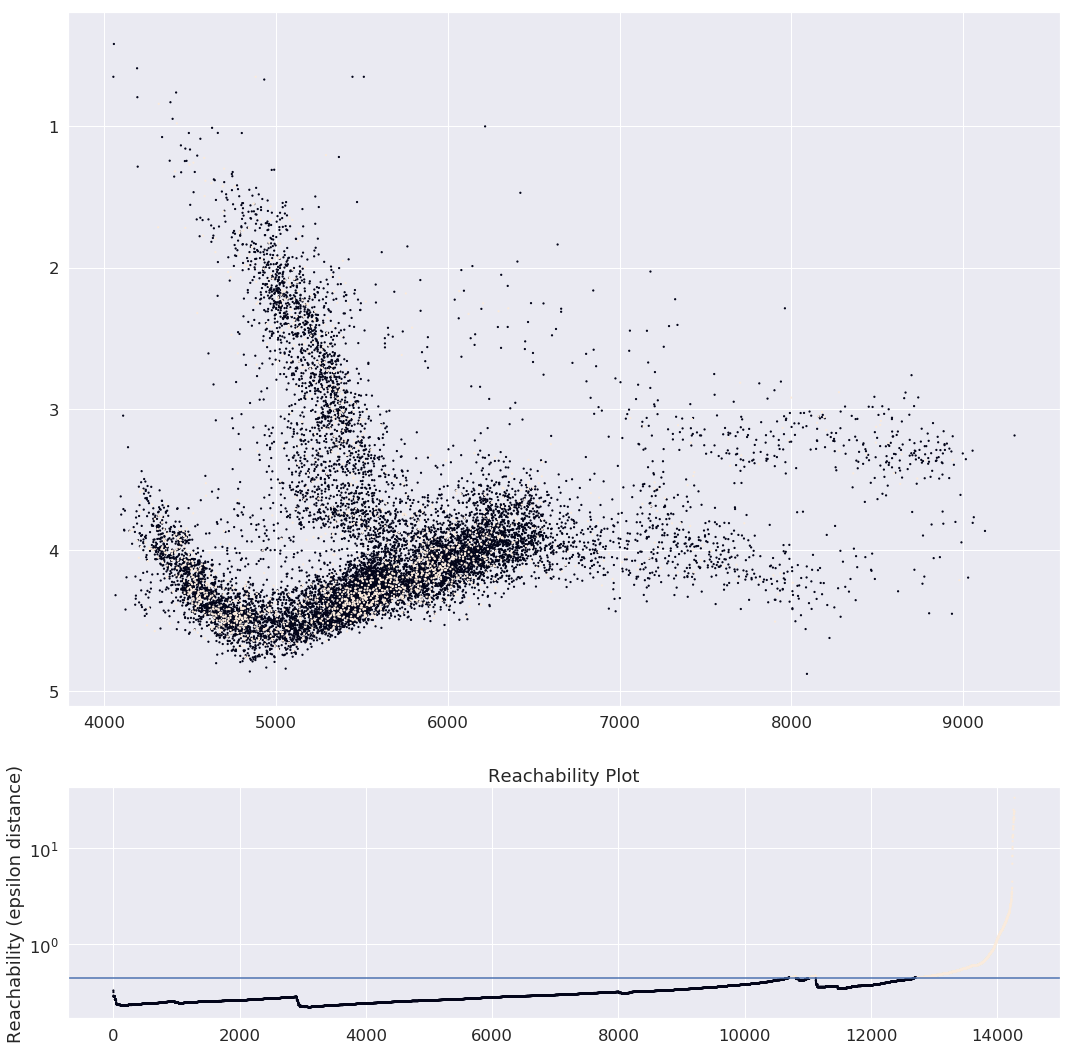

In [12]:
reach_size = (20, 7.5)

X_labelled = optics_labeller(X_clust, eps)
#X_labelled = X_labelled[(X_labelled['optics_label']==1)]

fig = plt.figure(figsize=(15, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax0.invert_yaxis()
ax0.scatter(X_labelled['Teff'], X_labelled['logg'], c=X_labelled['label'], s=1.5)
ax1 = plt.subplot(gs[1])
ax1.scatter(X_labelled['space'], X_labelled['reachability'], c=X_labelled['label'], s=1.5)
ax1.set_yscale("log")
ax1.axhline(eps)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')
plt.tight_layout()

In [13]:
# T-SNE
from sklearn.manifold import TSNE

projection = TSNE().fit_transform(X2_norm)

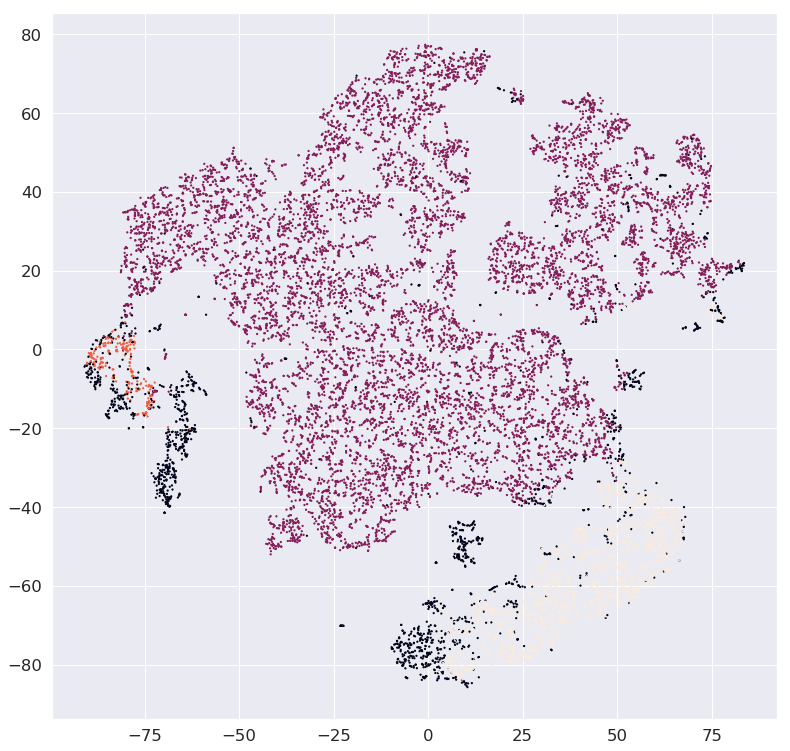

In [14]:
fig, ax = plt.subplots(figsize=(13, 13))
plt.scatter(*projection.T, s=1.5, c=X_clust['labels'])

In [15]:
plt.scatter(X2_norm)

TypeError: scatter() takes at least 2 arguments (1 given)

In [ ]:
plt.scatter(*projection.T, s=1.5, c=X2_norm['logg'])

In [ ]:
plt.scatter(*projection.T, s=1.5, c=X2_norm['feh'])

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=X2['Teff'], s = 100)
ax.legend()
plt.show()
plt.savefig('tsne_all_non_spectroscopic')

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=X2['logg'], s = 100)
ax.legend()
plt.show()
plt.savefig('tsne_all_non_spectroscopic')

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=X2['feh'], s = 100)
ax.legend()
plt.show()
plt.savefig('tsne_all_non_spectroscopic')

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')  
cluster.fit_predict(X) 

X2['labels']=cluster.labels_
X['labels']=cluster.labels_

In [ ]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
import hdbscan
import sys

clusterer = hdbscan.HDBSCAN(min_cluster_size=N).fit(X_norm)


len(X_clust.labels.unique())
#print X_clust['labels']
clusterer.condensed_tree_.plot()
#clusterer.single_linkage_tree_.plot()